Import libraries

In [1]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()

In [2]:
import tensorflow as tf
import tensorflow_io as tfio
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.ndimage import distance_transform_edt
import tifffile
from tensorflow.keras.callbacks import ModelCheckpoint

2025-04-16 08:30:50.765729: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-16 08:30:50.773209: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-16 08:30:50.775715: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Set the input paths and parameters

In [3]:
train_input_path = "/home/khietdang/Documents/khiet/treeRing/pith/train/x"
train_mask_path = "/home/khietdang/Documents/khiet/treeRing/pith/train/y"
test_input_path = "/home/khietdang/Documents/khiet/treeRing/pith/test/x"
test_mask_path = "/home/khietdang/Documents/khiet/treeRing/pith/test/y"
val_input_path = "/home/khietdang/Documents/khiet/treeRing/pith/val/x"
val_mask_path = "/home/khietdang/Documents/khiet/treeRing/pith/val/y"
model_path = "/home/khietdang/Documents/khiet/tree-ring-analyzer/src/models"

Get the paths of the images and masks

In [4]:
train_input_paths = [os.path.join(train_input_path, path) for path in os.listdir(train_input_path) if path.endswith(".tif")]
train_mask_paths = [os.path.join(train_mask_path, path) for path in os.listdir(train_mask_path) if path.endswith(".tif")]
print("Input images: " + str(len(train_input_paths)))
print("Input masks: " + str(len(train_mask_paths)))
print("---")
test_input_paths = [os.path.join(test_input_path, path) for path in os.listdir(test_input_path) if path.endswith(".tif")]
test_mask_paths = [os.path.join(test_mask_path, path) for path in os.listdir(test_mask_path) if path.endswith(".tif")]
print("Test images: " + str(len(test_input_paths)))
print("Test masks: " + str(len(test_mask_paths)))
val_input_paths = [os.path.join(val_input_path, path) for path in os.listdir(val_input_path) if path.endswith(".tif")]
val_mask_paths = [os.path.join(val_mask_path, path) for path in os.listdir(val_mask_path) if path.endswith(".tif")]
print("Val images: " + str(len(val_input_paths)))
print("Val masks: " + str(len(val_mask_paths)))
train_path_dataset = tf.data.Dataset.from_tensor_slices((train_input_paths, train_mask_paths))
test_path_dataset = tf.data.Dataset.from_tensor_slices((test_input_paths, test_mask_paths))
val_path_dataset = tf.data.Dataset.from_tensor_slices((val_input_paths, val_mask_paths))


Input images: 12300
Input masks: 12300
---
Test images: 13
Test masks: 13
Val images: 11
Val masks: 11


I0000 00:00:1744733358.621887  645959 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1744733358.644304  645959 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1744733358.644428  645959 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1744733358.647204  645959 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [5]:
for pair in train_path_dataset.take(1):
    print(pair)

(<tf.Tensor: shape=(), dtype=string, numpy=b'/home/khietdang/Documents/khiet/treeRing/pith/train/x/8 E 1 t_8\xc2\xb5m_x50_aug93.tif'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/home/khietdang/Documents/khiet/treeRing/pith/train/y/8 E 1 t_8\xc2\xb5m_x50_aug93.tif'>)


We define a function to read image/mask pairs.

In [ ]:
def read_images(img_path, label_path):
    def _load_image(path):
        path = path.numpy().decode("utf-8")  # Convert TensorFlow tensor to Python string
        img = tifffile.imread(path)  # Read TIFF image
        img = img.astype(np.float32)  # Convert image to float32 for TensorFlow compatibility
        return img

    img = tf.py_function(func=_load_image, inp=[img_path], Tout=tf.float32)  # Use tf.py_function
    img.set_shape([None, None, None])  # Set output shape for TensorFlow dataset compatibility

    seg = tf.py_function(func=_load_image, inp=[label_path], Tout=tf.float32)  # Use tf.py_function
    seg.set_shape([None, None, None])  # Set output shape for TensorFlow dataset compatibility

    return img / 255, seg / 255

Normalize images and masks.

We create a dataset containing pairs of images/masks.

In [8]:
train_dataset = train_path_dataset.map(lambda img_path, label: (read_images(img_path, label)), num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_path_dataset.map(lambda img_path, label: (read_images(img_path, label)), num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_path_dataset.map(lambda img_path, label: (read_images(img_path, label)), num_parallel_calls=tf.data.AUTOTUNE)

Trying to compensate for class imbalance.

Build train and validation batches.

In [9]:
BATCH_SIZE = 8
BUFFER_SIZE = 512
VALIDATION_SIZE = int(round((len(train_dataset) * 20) / 100))
# print("validation data size: " + str(VALIDATION_SIZE))
# print("train data size: " + str(len(train_dataset) - VALIDATION_SIZE))
# validation_batches = train_dataset.take(VALIDATION_SIZE).batch(BATCH_SIZE)
# train_batches = train_dataset.skip(VALIDATION_SIZE)
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

validation_batches = val_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
validation_batches = validation_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [10]:
train_dataset.take(1)
print(type(train_dataset))

<class 'tensorflow.python.data.ops.map_op._ParallelMapDataset'>


In [11]:
data = train_dataset.take(1)
mask = data.get_single_element()[1]
mask

<tf.Tensor: shape=(256, 256, 1), dtype=float32, numpy=
array([[[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       ...,

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]], dtype=float32)>

Display some random examples of pairs of input tiles and mask tiles.

(256, 256, 1)
(256, 256, 1)
tf.Tensor(0.0039169705, shape=(), dtype=float32) tf.Tensor(0.00076593616, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)


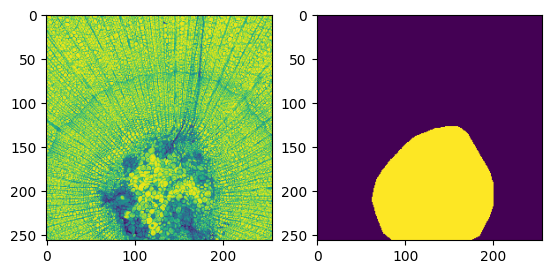

(256, 256, 1)
(256, 256, 1)
tf.Tensor(0.003921569, shape=(), dtype=float32) tf.Tensor(0.0007112188, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)


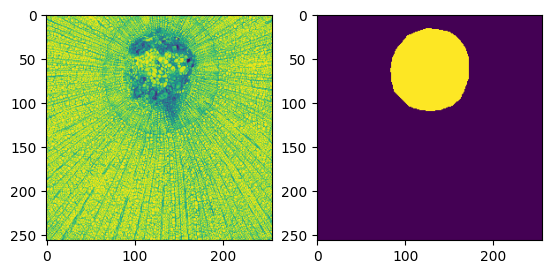

(256, 256, 1)
(256, 256, 1)
tf.Tensor(0.003921569, shape=(), dtype=float32) tf.Tensor(0.0007082046, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)


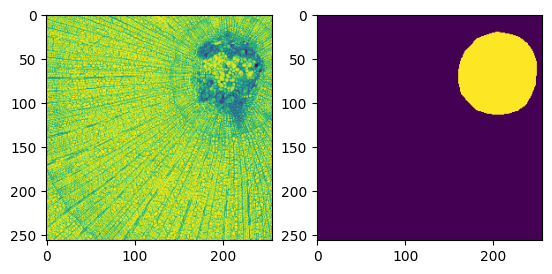

In [12]:
import matplotlib.pyplot as plt
N = 3
for image, mask in train_dataset.shuffle(len(train_dataset)).take(N):
    print(image.shape)
    print(mask.shape)
    print(tf.reduce_max(image), tf.reduce_min(image))
    print(tf.reduce_max(mask), tf.reduce_min(mask))
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(image)
    ax2.imshow(mask[:, :, 0])
    plt.show()

Building blocks for the UNet.

In [3]:
def double_conv_block(x, n_filters):
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   return x

def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)
   return f, p

def attention_gate(g, s, num_filters):
    Wg = layers.Conv2D(num_filters, 3, padding="same")(g)
    Wg = layers.BatchNormalization()(Wg)
 
    Ws = layers.Conv2D(num_filters, 3, padding="same")(s)
    Ws = layers.BatchNormalization()(Ws)
 
    out = layers.Activation("relu")(Wg + Ws)
    out = layers.Conv2D(num_filters, 3, padding="same")(out)
    out = layers.Activation("sigmoid")(out)
 
    return out * s
    
def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   s = attention_gate(x, conv_features, n_filters)
   # concatenate
   x = layers.concatenate([x, s])
   # dropout
   x = layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)
   return x

Function that builds the UNet

In [4]:
def build_unet_model():
   inputs = layers.Input(shape=(256,256,3))
   # encoder: contracting path - downsample
   # 1 - downsample
   f1, p1 = downsample_block(inputs, 64)
   # 2 - downsample
   f2, p2 = downsample_block(p1, 128)

   # 3 - downsample
   f3, p3 = downsample_block(p2, 256)
   # 4 - downsample
   f4, p4 = downsample_block(p3, 512)
   # 5 - bottleneck
   bottleneck = double_conv_block(p4, 1024)
   # decoder: expanding path - upsample
   # 6 - upsample
   u6 = upsample_block(bottleneck, f4, 512)
   # 7 - upsample
   u7 = upsample_block(u6, f3, 256)
   # 8 - upsample
   u8 = upsample_block(u7, f2, 128)
   # 9 - upsample
   u9 = upsample_block(u8, f1, 64)
   # outputs
   outputs = layers.Conv2D(1, (1,1), padding="same", activation = "sigmoid")(u9)
   # unet model with Keras Functional API
   unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
   return unet_model   

Build the UNet.

In [15]:
unet_model = build_unet_model()

Alternatively build the unet from the predifined keras models.

Define a loss function that is a weighted sum of dice and binary cross entropy.

In [16]:
@tf.keras.utils.register_keras_serializable()
def dice_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    return 1 - (2. * intersection + 1) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + 1)

@tf.keras.utils.register_keras_serializable()
def bce_dice_loss(bce_coef=0.5):
    @tf.keras.utils.register_keras_serializable()
    def bcl(y_true, y_pred):
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        dice = dice_loss(y_true, y_pred)
        return bce_coef * bce + (1.0 - bce_coef) * dice
    return bcl

Create an image of the UNet architecture.

In [17]:
keras.utils.plot_model(unet_model, show_shapes=True)
"model.png written"

You must install pydot (`pip install pydot`) for `plot_model` to work.


'model.png written'

Compile the model.

In [17]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss=bce_dice_loss(bce_coef=0.3),
                  metrics=['accuracy', 'precision', 'recall'])

Train the model.

In [18]:
checkpoint_callback = ModelCheckpoint(
    'best_model.h5',  # Filename
    monitor='val_loss',  # Metric to monitor
    save_best_only=True,  # Save only if it improves
    mode='min',  # Minimize the loss
    verbose=1
)

checkpoint_callback2 = ModelCheckpoint(
    'best_model.keras',  # Filename
    monitor='val_loss',  # Metric to monitor
    save_best_only=True,  # Save only if it improves
    mode='min',  # Minimize the loss
    verbose=1
)

NUM_EPOCHS = 100
keras.config.disable_traceback_filtering()
STEPS_PER_EPOCH = len(train_dataset) // BATCH_SIZE
VAL_SUBSPLITS = 5
VAL_LENGTH = VALIDATION_SIZE
VALIDATION_STEPS = VAL_LENGTH // BATCH_SIZE // VAL_SUBSPLITS
model_history = unet_model.fit(train_batches,
                              epochs=NUM_EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              validation_steps=VALIDATION_STEPS,
                              validation_data=validation_batches, 
                              verbose=2,
                              callbacks=[checkpoint_callback, checkpoint_callback2]
                              )

Epoch 1/100


I0000 00:00:1744733592.324895  646100 service.cc:146] XLA service 0x76b6fc0043b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744733592.324912  646100 service.cc:154]   StreamExecutor device (0): NVIDIA RTX 4000 Ada Generation Laptop GPU, Compute Capability 8.9
I0000 00:00:1744733601.201663  646100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_loss improved from inf to 0.64134, saving model to best_model.h5



Epoch 1: val_loss improved from inf to 0.64134, saving model to best_model.keras
1537/1537 - 69s - 45ms/step - accuracy: 0.9003 - loss: 0.6805 - precision: 0.1035 - recall: 5.7092e-04 - val_accuracy: 0.9223 - val_loss: 0.6413 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100


KeyboardInterrupt: 

Save a model.

In [18]:
import datetime
date = datetime.datetime.now()
unet_model.save(os.path.join(model_path, str(date) + ".keras"))

Save the weights only.

In [20]:
import datetime
date = datetime.datetime.now()
unet_model.save(os.path.join(model_path,  str(date) + ".h5"))

In [18]:
import json
json.dump(model_history.history, open('/home/khietdang/Documents/khiet/tree-ring-analyzer/src/history/Pith.json', 'w'))

In [18]:
print(model_history.history.keys())

dict_keys(['accuracy', 'loss', 'mse', 'precision', 'recall', 'val_accuracy', 'val_loss', 'val_mse', 'val_precision', 'val_recall'])


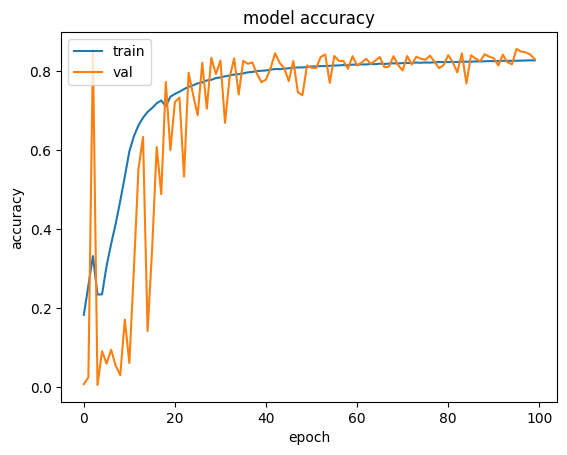

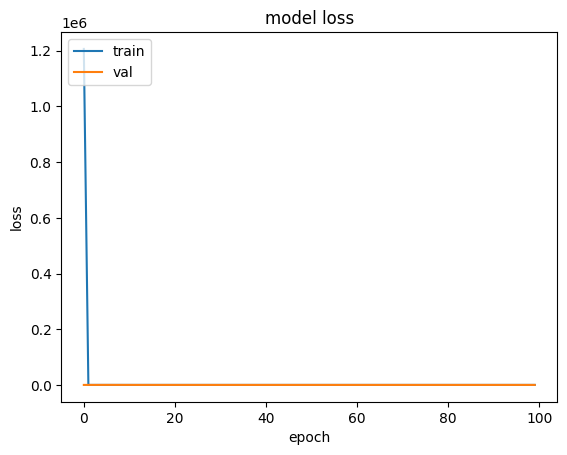

In [24]:
# summarize history for accuracy
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Load a saved model

In [21]:
model = "2025-03-10 08:15:16.877547.keras"
path = os.path.join(model_path, model)
unet_model = keras.models.load_model(path)

Load the weights only.

In [48]:
model = '2025-03-06 14:41:50.401830.weights.h5'
path = os.path.join(model_path, model)
unet_model.load_weights(path)

Evaluate model on test data.

In [49]:
test_batches = train_dataset.take(len(test_dataset)).batch(BATCH_SIZE)
score = unet_model.evaluate(test_batches, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.6888464689254761
Test accuracy: 0.0
